In [1]:
import os
import json
from stelaro.data import format, ncbi
import numpy as np
import random

DATA_DIRECTORY = "../data/"
SUMMARY_DIRECTORY = DATA_DIRECTORY + "ncbi_genome_summaries/"
NCBI_TAXONOMY_DIRECTORY = DATA_DIRECTORY + "ncbi_taxonomy/"
BERTAX_DIRECTORY = DATA_DIRECTORY + "bertax/final/"
BERTAX_DATASET_DIRECTORY = BERTAX_DIRECTORY + "final_model_data_seperate_fasta_per_superkingdom/data/fass2/projects/fk_read_classification/dna_sequences/fragments/genomic_fragments_80_big/"
BERTAX_DOMAINS = (
    "Archaea_db.fa",
    "Bacteria_db.fa",
    "Eukaryota_db.fa",
    "Viruses_db.fa",
)
BERTAX_STATISTIC_DIRECTORY = BERTAX_DIRECTORY + "statistics/"
PROCESSED_PRETRAINING_DATA = DATA_DIRECTORY + "bertax/pretraining/processed/"
SEQUENCE_LENGTH = 1500
N_MINIMUM_READS_PER_TAXON = 10_000


def mkdir(path: str) -> None:
    """Create a directory if it does not exist."""
    if not os.path.exists(path):
        os.makedirs(path)


mkdir(BERTAX_STATISTIC_DIRECTORY)

In [2]:
BERTAX_TRAIN = BERTAX_DIRECTORY + "train/"
BERTAX_VALIDATION = BERTAX_DIRECTORY + "validation/"
BERTAX_TEST = BERTAX_DIRECTORY + "test/"

import numpy as np
from torch.utils.data import DataLoader
import json
from torch.optim import Adam
import matplotlib.pyplot as plt
from time import time
from torch import nn, exp

from stelaro.data import format
from stelaro import models

LENGTH = 1500
BATCH_SIZE = 128


train_data = DataLoader(
    models.SyntheticTetramerDataset(BERTAX_TRAIN),
    batch_size=BATCH_SIZE,
    shuffle=True
)
validation_data = DataLoader(
    models.SyntheticTetramerDataset(BERTAX_VALIDATION),
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_data = DataLoader(
    models.SyntheticTetramerDataset(BERTAX_TEST),
    batch_size=BATCH_SIZE,
    shuffle=True
)

with open(BERTAX_DIRECTORY + "statistics/map.json", "r") as f:
    mapping = json.load(f)


def benchmark(
        classifier: models.BaseClassifier,
        name: str,
        max_epochs: int = 20,
        loss_fn = nn.CrossEntropyLoss(),
        evaluation_interval=5000,
        learning_rate: float = 0.001
    ):
    parameters = classifier.get_parameters()
    if parameters:
        optimizer = Adam(classifier.get_parameters(), lr=0.001)
        total_params = sum(param.numel() for param in parameters)
        print(f"Number of parameters: {total_params:_}")
    else:
        optimizer = None
    a = time()
    losses, f1, validation_losses = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=max_epochs,
        patience=3,
        loss_function=loss_fn,
        loss_function_type="supervised",
        evaluation_interval=evaluation_interval
    )
    b = time()
    print(f"Training took {(b - a):.3f} s.")
    if losses:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        x = list(range(len(losses)))
        ax[0].plot(x, losses, label="Training")
        ax[0].plot(x, validation_losses, label="Validation")
        ax[0].set(xlabel='Epochs', ylabel='Loss')
        ax[0].set_title("Normalized Loss Against Epochs")
        ax[0].legend()
        ax[1].set(xlabel='Epochs', ylabel="f1")
        ax[1].set_title("F1 Score")
        r = 0
        for f in f1:
            ax[1].plot(x, f, label=f'Rank {r}')
            r += 1
        ax[1].legend()
        fig.suptitle(f"Classification Training for {name}")
        plt.show()
    result = models.evaluate(classifier, test_data, "cuda", mapping)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"F1: {rounded_result}")
    result = models.evaluate_precision(classifier, test_data, "cuda", mapping)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"Precision: {rounded_result}")
    return classifier

# One-Shot

In [ ]:
from torch.optim import Adam
import torch
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel, MambaConfig
from mamba_ssm import Mamba
from torch import nn

# 256, 128, 2, 16, 8, 2, 0.1, batch 128, noClip, CEL
# F1: [0.94682, 0.88288]
# Precision: [0.94012, 0.88521]

# 256, 64, 2, 16, 8, 2, 0.1, batch 128, noClip, CEL
# F1: [0.92456, 0.8333]
# Precision: [0.93198, 0.84133]

# 256, 128, 2, 16, 8, 2, 0.1, batch 64, noClip, CEL
# F1: [0.94531, 0.88431]
# Precision: [0.94236, 0.88785]

# 256, 128, 2, 16, 8, 3, 0.1, batch 128, noClip, CEL*
# F1: [0.95005, 0.88783]
# Precision: [0.94598, 0.89011]

# 256, 256, 2, 16, 8, 2, 0.1, batch 64, 5 epochs, noClip, CEL
# F1: [0.95149, 0.88721]
# Precision: [0.95105, 0.88929]

# 256, 128, 2, 16, 16, 2, 0.1, batch 128, noClip, CEL
# F1: [0.95237, 0.88463]
# Precision: [0.95195, 0.88635]

# 256, 128, 2, 16, 16, 2, 0.1, batch 128, clip, focal mean
# F1: [0.94285, 0.87642]
# Precision: [0.93603, 0.87868]

# 256, 128, 2, 16, 16, 2, 0.1, batch 128, clip, focal sum
# F1: [0.94163, 0.87185]
# Precision: [0.93829, 0.87553]

# 256, 128, 2, 16, 16, 2, 0.1, batch 128, clip, penalty sum
# F1: [0.91501, 0.68972]
# Precision: [0.90453, 0.7091]

# 256, 128, 2, 16, 8, 2, 0.1, batch 128, noClip, focal sum
# F1: [0.93204, 0.85329]
# Precision: [0.93095, 0.85767]

# 256, 128, 3, 16, 8, 2, 0.1, batch 128, noClip, CEL
# F1: [0.90227, 0.80133]
# Precision: [0.89234, 0.80588]


class MambaSequenceClassifier(nn.Module):
    def __init__(
        self,
        N: int,
        num_classes: int,
        vocab_size: int = 256,
        d_model: int = 128,
        n_layers: int = 3,
        d_state: int = 16,
        d_conv: int = 4,
        expand: int = 2,
        pooling = "mean",
        dropout: float = 0.1,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([
            Mamba(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand)
            for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.classifier = nn.Linear(d_model, num_classes)
        self.pooling = pooling

    def forward(self, x: torch.LongTensor) -> torch.Tensor:
        h = self.embedding(x).to(dtype=torch.get_default_dtype())
        # h = h.to(torch.float16)
        for block in self.layers:
            h = block(h)   # each Mamba block returns [B, L, d_model]
        h = self.norm(h)
        pooled = h.mean(dim=1)  # [B, d_model]
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)  # [B, num_classes]
        return logits


classifier = models.Classifier(
    LENGTH // 4,
    mapping,
    "cuda",
    MambaSequenceClassifier,
    format.to_tetramers,
    True
)
# classifier.model = classifier.model.to(torch.float16)

import torch.nn.functional as F
def focal_loss(inputs, targets, alpha=1, gamma=2):
    num_classes = inputs.shape[1]
    targets = F.one_hot(targets, num_classes=num_classes).float()
    bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    pt = exp(-bce_loss)  # Convert BCE loss to probability
    focal_loss = alpha * (1 - pt) ** gamma * bce_loss  # Apply focal adjustment
    return focal_loss.sum()


def create_penalty_matrix(mapping):
    d = len(mapping)
    t = torch.zeros((d, d))
    n_ranks = len(mapping['0'])
    for i in mapping:
        for j in range(d):
            j = str(j)
            union_length = 0
            for a, b in zip(mapping[i], mapping[j]):
                if a == b:
                    union_length += 1
                else:
                    break
            penalty = ((n_ranks - union_length) / n_ranks) ** 0.5
            t[int(i), int(j)] = penalty
    return t
penalty_matrix = create_penalty_matrix(mapping).to("cuda")
def penalty_cross_entropy(y_pred, y_true):
    probs = F.softmax(y_pred, dim=-1)  # [B, M]
    penalty_rows = penalty_matrix[y_true]  # [B, M]
    loss = -torch.sum((1 - penalty_rows) * torch.log(probs + 1e-12), dim=-1)
    return loss.sum()
def hierarchical(input, targets):
    return models.penalized_cross_entropy(input, targets, penalty_matrix)


model = benchmark(
    classifier,
    "MAMBA",
    max_epochs=10,
    loss_fn=nn.CrossEntropyLoss()
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

Number of parameters: 388_785


 22%|██▏       | 2003/9196 [04:03<6:20:14,  3.17s/it] 

P: [0.57526, 0.22857]


 44%|████▎     | 4002/9196 [08:44<5:56:33,  4.12s/it]

P: [0.65106, 0.35171]


 65%|██████▌   | 6001/9196 [13:25<5:32:00,  6.23s/it]

P: [0.69989, 0.45002]


 87%|████████▋ | 8003/9196 [17:58<1:02:40,  3.15s/it]

P: [0.72618, 0.48692]


100%|██████████| 9196/9196 [20:25<00:00,  7.51it/s]  


1/10 T loss: 6.61341. V loss: 4.84294. F1: [0.7473, 0.50389]. P: [0.75105, 0.53675] Patience: 3


 22%|██▏       | 2003/9196 [04:20<6:17:59,  3.15s/it] 

P: [0.78049, 0.55876]


 44%|████▎     | 4003/9196 [08:41<4:33:56,  3.17s/it]

P: [0.79384, 0.58838]


 65%|██████▌   | 6003/9196 [13:06<2:47:26,  3.15s/it]

P: [0.80103, 0.60817]


 87%|████████▋ | 8003/9196 [17:29<1:02:31,  3.14s/it]

P: [0.80639, 0.63857]


100%|██████████| 9196/9196 [19:57<00:00,  7.68it/s]  


2/10 T loss: 4.13323. V loss: 3.68842. F1: [0.80875, 0.63045]. P: [0.79989, 0.64341] Patience: 3


 22%|██▏       | 2003/9196 [04:27<6:15:09,  3.13s/it] 

P: [0.82103, 0.64781]


 44%|████▎     | 4003/9196 [08:48<4:28:45,  3.11s/it]

P: [0.82164, 0.66638]


 65%|██████▌   | 6003/9196 [13:08<2:39:19,  2.99s/it]

P: [0.83035, 0.67798]


 87%|████████▋ | 8003/9196 [17:25<1:00:39,  3.05s/it]

P: [0.8352, 0.68557]


100%|██████████| 9196/9196 [19:49<00:00,  7.73it/s]  


3/10 T loss: 3.35514. V loss: 3.08872. F1: [0.84296, 0.69312]. P: [0.83396, 0.70252] Patience: 3


 22%|██▏       | 2002/9196 [26:50<4:12:30,  2.11s/it]   

P: [0.85194, 0.70102]


 44%|████▎     | 4003/9196 [30:21<2:18:18,  1.60s/it]

P: [0.85008, 0.70382]


 65%|██████▌   | 6003/9196 [34:18<2:43:12,  3.07s/it]

P: [0.84822, 0.71657]


 87%|████████▋ | 8003/9196 [38:46<1:03:00,  3.17s/it]

P: [0.85833, 0.72639]


100%|██████████| 9196/9196 [41:19<00:00,  3.71it/s]  


4/10 T loss: 2.91102. V loss: 2.77387. F1: [0.86056, 0.7215]. P: [0.85924, 0.72444] Patience: 3


 22%|██▏       | 2001/9196 [04:37<11:33:42,  5.78s/it]

P: [0.86929, 0.73768]


 44%|████▎     | 4002/9196 [09:18<5:57:19,  4.13s/it] 

P: [0.86356, 0.74011]


 65%|██████▌   | 6001/9196 [13:56<5:07:52,  5.78s/it]

P: [0.87261, 0.74341]


 87%|████████▋ | 8001/9196 [18:34<1:55:36,  5.80s/it]

P: [0.87052, 0.74563]


100%|██████████| 9196/9196 [21:10<00:00,  7.24it/s]  


5/10 T loss: 2.59942. V loss: 2.52903. F1: [0.87302, 0.7456]. P: [0.86696, 0.75424] Patience: 3


 22%|██▏       | 2002/9196 [04:41<8:11:37,  4.10s/it] 

P: [0.86764, 0.75526]


 44%|████▎     | 4002/9196 [09:22<5:54:18,  4.09s/it]

P: [0.88441, 0.76443]


 65%|██████▌   | 6002/9196 [14:03<3:38:29,  4.10s/it]

P: [0.87482, 0.76742]


 87%|████████▋ | 8002/9196 [18:45<1:21:35,  4.10s/it]

P: [0.88295, 0.77152]


100%|██████████| 9196/9196 [21:21<00:00,  7.18it/s]  


6/10 T loss: 2.36366. V loss: 2.31394. F1: [0.88486, 0.76933]. P: [0.88552, 0.77066] Patience: 3


 22%|██▏       | 2002/9196 [04:41<8:12:56,  4.11s/it] 

P: [0.88251, 0.77883]


 44%|████▎     | 4002/9196 [09:27<5:54:43,  4.10s/it]

P: [0.89717, 0.77904]


 65%|██████▌   | 6001/9196 [14:08<5:11:34,  5.85s/it]

P: [0.89149, 0.78166]


 87%|████████▋ | 8002/9196 [18:49<1:21:39,  4.10s/it]

P: [0.89935, 0.78397]


100%|██████████| 9196/9196 [21:25<00:00,  7.15it/s]  


7/10 T loss: 2.16952. V loss: 2.14979. F1: [0.89476, 0.78544]. P: [0.90153, 0.78891] Patience: 3


 22%|██▏       | 2002/9196 [04:41<8:12:25,  4.11s/it] 

P: [0.89517, 0.79322]


 44%|████▎     | 4002/9196 [09:22<5:58:38,  4.14s/it]

P: [0.89351, 0.79669]


 65%|██████▌   | 6002/9196 [14:03<3:39:00,  4.11s/it]

P: [0.90727, 0.79766]


 87%|████████▋ | 8002/9196 [18:49<1:25:25,  4.29s/it]

P: [0.90441, 0.80098]


100%|██████████| 9196/9196 [21:27<00:00,  7.14it/s]  


8/10 T loss: 2.00815. V loss: 2.05332. F1: [0.90019, 0.79307]. P: [0.89525, 0.79748] Patience: 3


 16%|█▌        | 1462/9196 [03:12<16:56,  7.61it/s]


KeyboardInterrupt: 

In [31]:
result = models.evaluate(classifier, test_data, "cuda", mapping)
rounded_result = [float(f"{r:.5}") for r in result]
print(f"F1: {rounded_result}")
result = models.evaluate_precision(classifier, test_data, "cuda", mapping)
rounded_result = [float(f"{r:.5}") for r in result]
print(f"Precision: {rounded_result}")

F1: [0.90227, 0.80133]
Precision: [0.89234, 0.80588]


In [12]:
print(mapping)
m = models.create_penalty_matrix(mapping)
print(m)

{'0': ['Archaea', 'Methanobacteriota'], '1': ['Archaea', 'Nitrososphaerota'], '2': ['Archaea', 'Thermoplasmatota'], '3': ['Archaea', 'Thermoproteota'], '4': ['Bacteria', 'Actinomycetota'], '5': ['Bacteria', 'Aquificota'], '6': ['Bacteria', 'Bacillota'], '7': ['Bacteria', 'Bacteroidota'], '8': ['Bacteria', 'Bdellovibrionota'], '9': ['Bacteria', 'Campylobacterota'], '10': ['Bacteria', 'Chlamydiota'], '11': ['Bacteria', 'Chlorobiota'], '12': ['Bacteria', 'Chloroflexota'], '13': ['Bacteria', 'Cyanobacteriota'], '14': ['Bacteria', 'Deinococcota'], '15': ['Bacteria', 'Fusobacteriota'], '16': ['Bacteria', 'Gemmatimonadota'], '17': ['Bacteria', 'Lentisphaerota'], '18': ['Bacteria', 'Mycoplasmatota'], '19': ['Bacteria', 'Myxococcota'], '20': ['Bacteria', 'Nitrospirota'], '21': ['Bacteria', 'Planctomycetota'], '22': ['Bacteria', 'Pseudomonadota'], '23': ['Bacteria', 'Rhodothermota'], '24': ['Bacteria', 'Spirochaetota'], '25': ['Bacteria', 'Thermodesulfobacteriota'], '26': ['Bacteria', 'Thermotog

# 1-NT Tokens

In [ ]:
from torch.optim import Adam
import torch
from mamba_ssm import Mamba
from torch import nn

# 256, 64, 2, 16, 8, 2, 0.1, batch 128
# F1: [0.88082, 0.78494]
# P: [0.89169, 0.80668]

class MambaSequenceClassifier(nn.Module):
    def __init__(
        self,
        N: int,
        num_classes: int,
        vocab_size: int = 4,
        d_model: int = 64,
        n_layers: int = 2,
        d_state: int = 16,
        d_conv: int = 8,
        expand: int = 2,
        pooling = "mean",
        dropout: float = 0.1,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([
            Mamba(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand)
            for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.classifier = nn.Linear(d_model, num_classes)
        self.pooling = pooling

    def forward(self, x: torch.LongTensor) -> torch.Tensor:
        h = self.embedding(x).to(dtype=torch.get_default_dtype())
        for block in self.layers:
            h = block(h)   # each Mamba block returns [B, L, d_model]
        h = self.norm(h)
        pooled = h.mean(dim=1)  # [B, d_model]
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)  # [B, num_classes]
        return logits


classifier = models.Classifier(LENGTH, mapping, "cuda", MambaSequenceClassifier, format.to_digits)
model = benchmark(
    classifier,
    "MAMBA",
    max_epochs=10,
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

Number of parameters: 69_873


 54%|█████▍    | 5001/9196 [28:50<8:21:51,  7.18s/it]

P: [0.87169, 0.7341]


100%|██████████| 9196/9196 [1:36:26<00:00,  1.59it/s]     


Halting evaluation after 28032 data points.
1/10 T loss: 13.99071. V loss: 10.32095. F1: [0.86647, 0.74595]. P: [0.88074, 0.77692] Patience: 3


 54%|█████▍    | 5000/9196 [1:05:05<51:28,  1.36it/s]  

Halting evaluation after 38144 data points.


 54%|█████▍    | 5001/9196 [1:05:36<11:29:05,  9.86s/it]

P: [0.90584, 0.8145]


100%|██████████| 9196/9196 [1:57:10<00:00,  1.31it/s]   


Halting evaluation after 38144 data points.
2/10 T loss: 8.43410. V loss: 8.98794. F1: [0.88082, 0.78494]. P: [0.89169, 0.80668] Patience: 3


  1%|          | 94/9196 [01:11<1:54:40,  1.32it/s]


KeyboardInterrupt: 

# Pretraining

In [ ]:
# Obtain pretraining data
DATA_DIRECTORY = "../data/"
BERTAX_DIRECTORY = DATA_DIRECTORY + "bertax/pretraining/"
BERTAX_DATASET_DIRECTORY = BERTAX_DIRECTORY + "pretraining_dataset/data/fass2/projects/fk_read_classification/dna_sequences/fragments/genomic_fragments_80/"
BERTAX_DOMAINS = (
    "Archaea_db.fa",
    "Bacteria_db.fa",
    "Eukaryota_db.fa",
    "Viruses_db.fa",
)

total = 0
for domain in BERTAX_DOMAINS:
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        for line in f:
            if line.startswith(">"):
                total += 1
    print(f"Domain: {domain}. Total: {total}")

x = np.zeros((total, 1500 // 4), dtype=np.uint8)
mkdir(PROCESSED_PRETRAINING_DATA)
i = 0
for domain in BERTAX_DOMAINS:
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        for line in f:
            if not line.startswith(">"):
                sequence = line.strip().upper()
                characters = set(sequence)
                if len(characters) == 4:
                    encoding = format.encode_tetramer(sequence)
                    x[i] = encoding
                    i += 1
np.save(PROCESSED_PRETRAINING_DATA + "/x.npy", x)

In [9]:
from torch.optim import Adam, AdamW
import torch
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel, MambaConfig
from mamba_ssm import Mamba
from torch import nn


# 128, 2, 16, 4, 2, mean, 0.1, noClip, pretraining: 10_000 -> 0.15 MLM
# F1: [0.9365, 0.86395]
# Precision: [0.93262, 0.87061]

# 128, 2, 16, 4, 2, mean, 0.1, noClip, pretraining: 20_000 -> 0.15 MLM
# Precision: [0.93845, 0.86496] (incomplete training - no difference with 10k steps)
# Lowest MLM loss: 0.1352
# Fine-tuning:
#   Epoch 1: F1: [0.88529, 0.75644]. P: [0.89593, 0.76523]
#   Epoch 2: F1: [0.91113, 0.81615]. P: [0.91365, 0.82102]

# 128, 2, 16, 4, 2, mean, 0.1, noClip, pretraining: 100_000 -> 0.15 MLM
# 1/10 T loss: 2.97148. V loss: 2.46173. F1: [0.87928, 0.75458]. P: [0.87739, 0.77189] Patience: 3
# 2/10 T loss: 1.97898. V loss: 1.84719. F1: [0.91845, 0.82066]. P: [0.92227, 0.82479] Patience: 3
# 5/10 T loss: 1.37992. V loss: 1.43371. F1: [0.9326, 0.86184]. P: [0.92561, 0.86369]

# 128, 2, 16, 4, 2, mean, 0.1, noClip, pretraining: 50_000 new -> 0.15 MLM
# 1/10 T loss: 3.11947. V loss: 2.29345. F1: [0.89625, 0.77654]. P: [0.89769, 0.78591] Patience: 3
# 2/10 T loss: 2.04814. V loss: 1.93529. F1: [0.91427, 0.81052]. P: [0.913, 0.81998] Patience: 3
# 3/10 T loss: 1.70350. V loss: 1.71731. F1: [0.92385, 0.83688]. P: [0.9214, 0.84447] Patience: 3

# 128, 2, 16, 4, 2, mean, 0.1, noClip, pretraining: 40_000 new -> 0.15 MLM, lr = 0.0001
# 1/10 T loss: 3.12365. V loss: 2.35835. F1: [0.8859, 0.76903]. P: [0.88096, 0.77557] Patience: 3
# 2/10 T loss: 1.99888. V loss: 1.85153. F1: [0.9151, 0.8191]. P: [0.9125, 0.82259] Patience: 3
# 3/10 T loss: 1.68860. V loss: 1.62224. F1: [0.92761, 0.84333]. P: [0.92996, 0.84681] Patience: 3

# 128, 3 (norms), 16, 4, 2, mean, 0.1, clip, pretraining: 10_000 new -> 0.2 MLM, lr = 0.0001


class MambaBlock(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )

    def forward(self, x):
        # Pre-norm + residual connection
        return x + self.mamba(self.norm(x))


class MambaSequenceClassifier(nn.Module):
    def __init__(
        self,
        N: int,
        num_classes: int,
        vocab_size: int = 256,
        d_model: int = 128,
        n_layers: int = 3,
        d_state: int = 16,
        d_conv: int = 4,
        expand: int = 2,
        pooling = "mean",
        dropout: float = 0.1,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, d_model)
        self.layers = nn.ModuleList([
            # Mamba(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand)
            MambaBlock(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand)
            for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        self.classifier = nn.Linear(d_model, num_classes)
        # self.classifier = nn.Sequential(
        #     nn.Conv1d(128, 256, kernel_size=5, padding=2),
        #     nn.ReLU(),
        #     nn.Flatten(),
        #     nn.Linear(N * 256, num_classes),
        # )

        self.pooling = pooling
        self.mlm_head = nn.Linear(d_model, vocab_size + 1)
        self.mlm_head.weight = self.embedding.weight

    def forward(self, x: torch.LongTensor, mlm=None) -> torch.Tensor:
        h = self.embedding(x)#.to(dtype=torch.get_default_dtype())
        for block in self.layers:
            h = block(h)   # each Mamba block returns [B, L, d_model]
        h = self.norm(h)
        if mlm is not None:
            logits = self.mlm_head(h)  # [B, L, vocab_size + 1]
            return logits
        else:
            # pooled = h[:, 0]
            pooled = h.mean(dim=1)  # [B, d_model]
            pooled = self.dropout(pooled)
            # pooled = pooled.permute(0, 2, 1)
            logits = self.classifier(pooled)  # [B, num_classes]
            return logits


classifier = models.Classifier(
    LENGTH // 4,
    mapping,
    "cuda",
    MambaSequenceClassifier,
    format.to_tetramers,
    True
)

print("Pretraining:")
optimizer = AdamW(classifier.get_parameters(), lr=0.001)
pretraining_data = DataLoader(
    models.SyntheticTetramerDataset(PROCESSED_PRETRAINING_DATA, labels=False),
    batch_size=BATCH_SIZE,
    shuffle=True
)
classifier.pretrain(
    pretraining_data,
    optimizer,
    10_000,
    256,
    patience=3,
    mlm_probability=0.25
)

print("Fine-tuning:")
model = benchmark(
    classifier,
    "MAMBA",
    max_epochs=10,
    loss_fn=nn.CrossEntropyLoss(),
    evaluation_interval=2000,
    learning_rate=0.0001
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

Fine-tuning:
Number of parameters: 389_938


 22%|██▏       | 2001/9196 [03:41<9:12:55,  4.61s/it]

P: [0.80326, 0.64982]


 44%|████▎     | 4001/9196 [07:23<6:36:08,  4.58s/it]

P: [0.85748, 0.70958]


 65%|██████▌   | 6001/9196 [11:08<4:09:57,  4.69s/it]

P: [0.88819, 0.7525]


 87%|████████▋ | 8001/9196 [15:02<1:41:36,  5.10s/it]

P: [0.89519, 0.77108]


100%|██████████| 9196/9196 [17:18<00:00,  8.86it/s]  


1/10 T loss: 3.19294. V loss: 2.32218. F1: [0.89688, 0.77193]. P: [0.90517, 0.78354] Patience: 3


 22%|██▏       | 2002/9196 [04:06<7:58:51,  3.99s/it] 

P: [0.89802, 0.80257]


 44%|████▎     | 4002/9196 [08:26<6:06:06,  4.23s/it]

P: [0.90943, 0.80979]


 65%|██████▌   | 6002/9196 [12:33<3:16:53,  3.70s/it]

P: [0.92629, 0.81882]


 87%|████████▋ | 8002/9196 [16:39<1:16:15,  3.83s/it]

P: [0.90996, 0.82479]


100%|██████████| 9196/9196 [19:04<00:00,  8.04it/s]  


2/10 T loss: 1.95762. V loss: 1.75689. F1: [0.92233, 0.82708]. P: [0.92497, 0.83141] Patience: 3


 22%|██▏       | 2002/9196 [03:59<7:22:55,  3.69s/it] 

P: [0.91814, 0.83478]


 44%|████▎     | 4002/9196 [08:01<5:21:18,  3.71s/it]

P: [0.93004, 0.84943]


 65%|██████▌   | 6001/9196 [12:09<4:51:13,  5.47s/it]

P: [0.93896, 0.84498]


 87%|████████▋ | 8002/9196 [16:12<1:16:59,  3.87s/it]

P: [0.93467, 0.85354]


100%|██████████| 9196/9196 [18:24<00:00,  8.32it/s]  


3/10 T loss: 1.57684. V loss: 1.56207. F1: [0.93461, 0.84664]. P: [0.93917, 0.85025] Patience: 3


 22%|██▏       | 2002/9196 [04:02<8:10:50,  4.09s/it] 

P: [0.93231, 0.85553]


 44%|████▎     | 4002/9196 [08:11<5:34:05,  3.86s/it]

P: [0.93944, 0.85901]


 50%|█████     | 4622/9196 [09:30<09:24,  8.10it/s]  


KeyboardInterrupt: 

# Frozen Initial Layers

In [ ]:
from torch.optim import Adam, AdamW
import torch
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel, MambaConfig
from mamba_ssm import Mamba
from torch import nn


class MambaBlock(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )

    def forward(self, x):
        # Pre-norm + residual connection
        return x + self.mamba(self.norm(x))


class MambaSequenceClassifier(nn.Module):
    def __init__(
        self,
        N: int,
        num_classes: int,
        vocab_size: int = 256,
        d_model: int = 128,
        n_layers: int = 4,
        d_state: int = 16,
        d_conv: int = 4,
        expand: int = 2,
        pooling = "mean",
        dropout: float = 0.1,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, d_model)
        self.first_layers = nn.ModuleList([
            MambaBlock(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand)
            for _ in range(n_layers)
        ])
        self.last_layers = nn.ModuleList([
            MambaBlock(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand)
            for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        self.classifier = nn.Linear(d_model, num_classes)
        # self.classifier = nn.Sequential(
        #     nn.Conv1d(128, 256, kernel_size=5, padding=2),
        #     nn.ReLU(),
        #     nn.Flatten(),
        #     nn.Linear(N * 256, num_classes),
        # )

        self.pooling = pooling
        self.mlm_head = nn.Linear(d_model, vocab_size + 1)
        # self.mlm_head.weight = self.embedding.weight

    def forward(self, x: torch.LongTensor, mlm=None) -> torch.Tensor:
        h = self.embedding(x)#.to(dtype=torch.get_default_dtype())
        if mlm is not None:
            for block in self.first_layers:
                h = block(h)   # each Mamba block returns [B, L, d_model]
            for block in self.last_layers:
                h = block(h)   # each Mamba block returns [B, L, d_model]
            h = self.norm(h)
            logits = self.mlm_head(h)  # [B, L, vocab_size + 1]
            return logits
        else:
            for block in self.first_layers:
                h = block(h)   # each Mamba block returns [B, L, d_model]
            for block in self.last_layers:
                h = block(h)   # each Mamba block returns [B, L, d_model]
            h = self.norm(h)
            pooled = h.mean(dim=1)  # [B, d_model]
            pooled = self.dropout(pooled)
            # pooled = pooled.permute(0, 2, 1)
            logits = self.classifier(pooled)  # [B, num_classes]
            return logits

    def freeze_base(self):
        for block in self.first_layers:
            for param in block.parameters():
                param.requires_grad = False

    def unfreeze_base(self):
        for block in self.first_layers:
            for param in block.parameters():
                param.requires_grad = True


classifier = models.Classifier(
    LENGTH // 4,
    mapping,
    "cuda",
    MambaSequenceClassifier,
    format.to_tetramers,
    True
)

print("Pretraining:")
optimizer = AdamW(classifier.get_parameters(), lr=0.001)
pretraining_data = DataLoader(
    models.SyntheticTetramerDataset(PROCESSED_PRETRAINING_DATA, labels=False),
    batch_size=BATCH_SIZE,
    shuffle=True
)
classifier.pretrain(
    pretraining_data,
    optimizer,
    20_000,
    256,
    patience=3,
    mlm_probability=0.3
)
# classifier.model.freeze_base()

print("Fine-tuning:")
model = benchmark(
    classifier,
    "MAMBA",
    max_epochs=10,
    loss_fn=nn.CrossEntropyLoss(),
    evaluation_interval=2000,
    learning_rate=0.0001
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)


# 128, 3 / 3, 16, 4, 2, mean, 0.1, clip, pretraining: None
# 1/10 T loss: 3.08970. V loss: 1.81286. F1: [0.91764, 0.82083]. P: [0.9162, 0.82467] Patience: 3
# 2/10 T loss: 1.49454. V loss: 1.34284. F1: [0.94197, 0.87123]. P: [0.94196, 0.87661] Patience: 3

# 128, 3 / 3, 16, 4, 2, mean, 0.1, clip, pretraining: 5k, freeze
# 1/10 T loss: 9.88273. V loss: 9.09895. F1: [0.35103, 0.10588]. P: [0.38429, 0.12499]

# 128, 2 / 2, 16, 4, 2, mean, 0.1, clip, pretraining: 10k, freeze
# 1/10 T loss: 3.26994. V loss: 2.42430. F1: [0.89472, 0.75593]. P: [0.89744, 0.76282] Patience: 3

# 128, 2 / 2, 16, 4, 2, mean, 0.1, clip, pretraining: 20k, freeze
# 1/10 T loss: 4.59330. V loss: 3.32864. F1: [0.84704, 0.67053]. P: [0.84721, 0.67978] Patience: 3
# 2/10 T loss: 2.78251. V loss: 2.51102. F1: [0.88506, 0.74861]. P: [0.88034, 0.75483] Patience: 3

# 128, 2 / 2, 16, 4, 2, mean, 0.1, clip, pretraining: 20k, no freeze, span
# 1/10 T loss: 3.30888. V loss: 2.14662. F1: [0.90234, 0.79144]. P: [0.90968, 0.79664] Patience: 3
# 2/10 T loss: 1.76234. V loss: 1.54726. F1: [0.93, 0.84993]. P: [0.92694, 0.85452] Patience: 3
# 3/10 T loss: 1.34409. V loss: 1.35847. F1: [0.93591, 0.86929]. P: [0.93794, 0.87497] Patience: 3

# 128, 2 / 2, 16, 4, 2, mean, 0.1, clip, pretraining: 10k, no freeze, span
# 1/10 T loss: 3.32805. V loss: 1.91426. F1: [0.91257, 0.81601]. P: [0.91242, 0.81589] Patience: 3
# 2/10 T loss: 1.67703. V loss: 1.49529. F1: [0.93111, 0.85618]. P: [0.9346, 0.86045] Patience: 3
# 3/10 T loss: 1.33147. V loss: 1.36263. F1: [0.93998, 0.86843]. P: [0.93879, 0.87145] Patience: 3

# 128, 2 / 2, 16, 4, 2, mean, 0.1, clip, pretraining: 40k, no freeze, span
# 1/10 T loss: 2.66859. V loss: 1.88050. F1: [0.91414, 0.81202]. P: [0.90473, 0.82252] Patience: 3
# 2/10 T loss: 1.59724. V loss: 1.41483. F1: [0.94162, 0.86189]. P: [0.94196, 0.86865] Patience: 3
# 3/10 T loss: 1.28868. V loss: 1.25275. F1: [0.94469, 0.8754]. P: [0.94138, 0.87864] Patience: 3

# 128, 2 / 2, 16, 4, 2, mean, 0.1, clip, pretraining: 20k, no freeze, all masked 15 %
# 1/10 T loss: 2.53448. V loss: 1.84904. F1: [0.91666, 0.8147]. P: [0.90713, 0.82688] Patience: 3
# 2/10 T loss: 1.52909. V loss: 1.40461. F1: [0.94339, 0.86156]. P: [0.9458, 0.86432] Patience: 3
# 3/10 T loss: 1.23919. V loss: 1.23687. F1: [0.95087, 0.8776]. P: [0.95401, 0.87988] Patience: 3

# 128, 3 / 3, 16, 4, 2, mean, 0.1, clip, pretraining: 20k, no freeze, all masked 10 %
# 1/10 T loss: 2.03367. V loss: 1.45920. F1: [0.93885, 0.85342]. P: [0.93636, 0.86178] Patience: 3
# 2/10 T loss: 1.20462. V loss: 1.13109. F1: [0.95273, 0.88658]. P: [0.95174, 0.88691] Patience: 3
# 3/10 T loss: 0.97474. V loss: 1.03495. F1: [0.95888, 0.89874]. P: [0.95798, 0.90307] Patience: 3
# 4/10 T loss: 0.84054. V loss: 0.89632. F1: [0.96534, 0.91211]. P: [0.96508, 0.91451] Patience: 3


# 10 %
# Number of parameters: 957_362
#   0%|          | 1/9196 [00:00<2:32:11,  1.01it/s]
# Halting evaluation after 60288 data points.
#   0%|          | 2/9196 [00:31<47:15:32, 18.50s/it]
# P: [0.33365, 0.01094]
#  11%|█         | 1000/9196 [03:59<28:13,  4.84it/s]
# Halting evaluation after 61824 data points.
#  11%|█         | 1001/9196 [04:30<21:17:30,  9.35s/it]
# P: [0.88623, 0.69175]
#  22%|██▏       | 2000/9196 [07:58<25:29,  4.70it/s]
# Halting evaluation after 58624 data points.
#  22%|██▏       | 2001/9196 [08:29<18:41:39,  9.35s/it]
# P: [0.90945, 0.75627]
#  43%|████▎     | 4000/9196 [15:27<18:08,  4.77it/s]
# Halting evaluation after 59264 data points.
#  44%|████▎     | 4001/9196 [15:58<13:32:05,  9.38s/it]
# P: [0.9099, 0.79962]

# 5 %
# Number of parameters: 957_362
#   0%|          | 1/9196 [00:00<50:19,  3.04it/s]
# Halting evaluation after 57088 data points.
#   0%|          | 2/9196 [00:31<46:32:23, 18.22s/it]
# P: [0.41815, 0.0070681]
#  11%|█         | 1000/9196 [04:01<28:21,  4.82it/s]
# Halting evaluation after 59776 data points.
#  11%|█         | 1001/9196 [04:32<21:16:29,  9.35s/it]
# P: [0.86172, 0.67681]
#  22%|██▏       | 2000/9196 [07:59<24:53,  4.82it/s]
# Halting evaluation after 57984 data points.
#  22%|██▏       | 2001/9196 [08:30<18:40:29,  9.34s/it]
# P: [0.87491, 0.73942]
#  43%|████▎     | 4000/9196 [15:28<18:06,  4.78it/s]
# Halting evaluation after 59648 data points.
#  44%|████▎     | 4002/9196 [15:59<9:31:19,  6.60s/it]
# P: [0.92555, 0.7918]
#  65%|██████▌   | 6000/9196 [22:58<11:55,  4.47it/s]
# Halting evaluation after 59392 data points.
#  65%|██████▌   | 6001/9196 [23:28<8:18:01,  9.35s/it]
# P: [0.91853, 0.82185]

# 0 %
# Number of parameters: 957_362
#   0%|          | 2/9196 [00:30<46:04:33, 18.04s/it]
# P: [0.35437, 0.014502]
#  11%|█         | 1000/9196 [03:58<28:27,  4.80it/s]
# Halting evaluation after 60032 data points.
#  11%|█         | 1001/9196 [04:29<21:17:28,  9.35s/it]
# P: [0.78984, 0.51625]
#  22%|██▏       | 2000/9196 [07:57<25:02,  4.79it/s]
# Halting evaluation after 60416 data points.
#  22%|██▏       | 2001/9196 [08:28<18:42:27,  9.36s/it]
# P: [0.83578, 0.62203]
#  43%|████▎     | 4000/9196 [15:23<17:57,  4.82it/s]
# Halting evaluation after 60416 data points.
#  44%|████▎     | 4001/9196 [15:53<13:29:12,  9.35s/it]
# P: [0.86769, 0.75943]
#  65%|██████▌   | 6000/9196 [22:51<11:10,  4.77it/s]
# Halting evaluation after 59392 data points.
#  65%|██████▌   | 6001/9196 [23:21<8:18:22,  9.36s/it]
# P: [0.89947, 0.80061]

/mnt/d/maitrise/stelaro/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pretraining:


  3%|▎         | 500/19473 [02:17<1:24:53,  3.72it/s]

Step: 500. Epoch: 1. MLM loss: 5.3348. Patience: 3
Average entropy: 5.2994. Correct predictions: 146417 / 7200686 (2.0334 %).


  5%|▌         | 1000/19473 [04:32<1:23:29,  3.69it/s]

Step: 1000. Epoch: 1. MLM loss: 5.2464. Patience: 3
Average entropy: 5.1635. Correct predictions: 176006 / 7201752 (2.4439 %).


  8%|▊         | 1500/19473 [06:47<1:20:56,  3.70it/s]

Step: 1500. Epoch: 1. MLM loss: 5.2245. Patience: 3
Average entropy: 5.1515. Correct predictions: 180012 / 7202400 (2.4993 %).


 10%|█         | 2000/19473 [09:03<1:19:05,  3.68it/s]

Step: 2000. Epoch: 1. MLM loss: 5.2166. Patience: 3
Average entropy: 5.1437. Correct predictions: 181911 / 7201691 (2.5259 %).


 13%|█▎        | 2500/19473 [11:18<1:16:59,  3.67it/s]

Step: 2500. Epoch: 1. MLM loss: 5.2045. Patience: 3
Average entropy: 5.1177. Correct predictions: 188454 / 7200632 (2.6172 %).


 15%|█▌        | 3000/19473 [13:34<1:14:48,  3.67it/s]

Step: 3000. Epoch: 1. MLM loss: 5.2015. Patience: 3
Average entropy: 5.0864. Correct predictions: 188014 / 7198629 (2.6118 %).


 18%|█▊        | 3500/19473 [15:52<1:13:28,  3.62it/s]

Step: 3500. Epoch: 1. MLM loss: 5.1959. Patience: 3
Average entropy: 5.0592. Correct predictions: 191481 / 7199685 (2.6596 %).


 21%|██        | 4000/19473 [18:12<1:11:24,  3.61it/s]

Step: 4000. Epoch: 1. MLM loss: 5.1916. Patience: 3
Average entropy: 5.0214. Correct predictions: 192323 / 7200514 (2.671 %).


 23%|██▎       | 4500/19473 [20:30<1:09:24,  3.60it/s]

Step: 4500. Epoch: 1. MLM loss: 5.1874. Patience: 3
Average entropy: 4.982. Correct predictions: 195279 / 7201607 (2.7116 %).


 26%|██▌       | 5000/19473 [22:47<1:05:38,  3.67it/s]

Step: 5000. Epoch: 1. MLM loss: 5.1855. Patience: 3
Average entropy: 4.9465. Correct predictions: 196856 / 7199420 (2.7343 %).


 28%|██▊       | 5500/19473 [25:03<1:03:30,  3.67it/s]

Step: 5500. Epoch: 1. MLM loss: 5.1856. Patience: 3
Average entropy: 4.8863. Correct predictions: 193157 / 7197670 (2.6836 %).


 31%|███       | 6000/19473 [27:20<1:01:50,  3.63it/s]

Step: 6000. Epoch: 1. MLM loss: 5.1815. Patience: 2
Average entropy: 4.8446. Correct predictions: 196546 / 7199389 (2.73 %).


 33%|███▎      | 6500/19473 [29:36<58:53,  3.67it/s]  

Step: 6500. Epoch: 1. MLM loss: 5.1813. Patience: 2
Average entropy: 4.8327. Correct predictions: 195325 / 7199206 (2.7131 %).


 36%|███▌      | 7000/19473 [31:52<56:32,  3.68it/s]

Step: 7000. Epoch: 1. MLM loss: 5.1793. Patience: 2
Average entropy: 4.7876. Correct predictions: 197887 / 7203391 (2.7471 %).


 39%|███▊      | 7500/19473 [34:08<54:17,  3.68it/s]

Step: 7500. Epoch: 1. MLM loss: 5.1737. Patience: 2
Average entropy: 4.7707. Correct predictions: 201147 / 7203915 (2.7922 %).


 41%|████      | 8000/19473 [36:24<51:57,  3.68it/s]

Step: 8000. Epoch: 1. MLM loss: 5.1753. Patience: 2
Average entropy: 4.7916. Correct predictions: 199828 / 7199650 (2.7755 %).


 44%|████▎     | 8500/19473 [38:40<49:43,  3.68it/s]

Step: 8500. Epoch: 1. MLM loss: 5.1726. Patience: 1
Average entropy: 4.7989. Correct predictions: 201632 / 7204012 (2.7989 %).


 46%|████▌     | 9000/19473 [40:56<47:25,  3.68it/s]

Step: 9000. Epoch: 1. MLM loss: 5.1716. Patience: 1
Average entropy: 4.8109. Correct predictions: 201587 / 7197654 (2.8007 %).


 49%|████▉     | 9499/19473 [43:11<45:07,  3.68it/s]

Step: 9500. Epoch: 1. MLM loss: 5.1724. Patience: 1
Average entropy: 4.8166. Correct predictions: 199399 / 7198504 (2.77 %).
Overfitting; stopping early.


 49%|████▉     | 9499/19473 [43:12<45:22,  3.66it/s]


Fine-tuning:
Number of parameters: 1_006_514


  0%|          | 1/9196 [00:00<2:32:17,  1.01it/s]

Halting evaluation after 49152 data points.


  0%|          | 2/9196 [00:32<47:42:13, 18.68s/it]

P: [0.38086, 0.024069]


 11%|█         | 1000/9196 [05:00<36:44,  3.72it/s]

Halting evaluation after 49024 data points.


 11%|█         | 1001/9196 [05:31<21:22:18,  9.39s/it]

P: [0.88894, 0.71968]


 22%|██▏       | 2000/9196 [09:59<32:08,  3.73it/s]   

Halting evaluation after 49024 data points.


 22%|██▏       | 2001/9196 [10:30<18:46:14,  9.39s/it]

P: [0.89917, 0.77478]


 43%|████▎     | 4000/9196 [19:26<23:13,  3.73it/s]   

Halting evaluation after 49024 data points.


 44%|████▎     | 4001/9196 [19:57<13:33:00,  9.39s/it]

P: [0.90859, 0.80899]


 65%|██████▌   | 6000/9196 [28:53<14:15,  3.73it/s]   

Halting evaluation after 49024 data points.


 65%|██████▌   | 6001/9196 [29:24<8:19:37,  9.38s/it]

P: [0.92684, 0.8367]


 87%|████████▋ | 8000/9196 [38:18<05:19,  3.74it/s]  

Halting evaluation after 49280 data points.


 87%|████████▋ | 8001/9196 [38:49<3:07:08,  9.40s/it]

P: [0.94329, 0.84941]


100%|██████████| 9196/9196 [44:10<00:00,  3.47it/s]  


Halting evaluation after 48896 data points.
1/10 T loss: 2.09147. V loss: 1.52797. F1: [0.9361, 0.84797]. P: [0.93469, 0.85665] Patience: 3


  0%|          | 1/9196 [00:01<4:32:45,  1.78s/it]

Halting evaluation after 49152 data points.


  0%|          | 2/9196 [00:32<47:59:59, 18.79s/it]

P: [0.93459, 0.85684]


 11%|█         | 1000/9196 [05:00<36:40,  3.72it/s]

Halting evaluation after 49024 data points.


 11%|█         | 1001/9196 [05:30<21:26:00,  9.42s/it]

P: [0.93638, 0.87065]


 22%|██▏       | 2000/9196 [09:59<32:10,  3.73it/s]   

Halting evaluation after 49024 data points.


 22%|██▏       | 2001/9196 [10:29<18:45:37,  9.39s/it]

P: [0.93604, 0.87131]


 43%|████▎     | 4000/9196 [19:26<23:13,  3.73it/s]   

Halting evaluation after 49024 data points.


 44%|████▎     | 4001/9196 [19:56<13:32:36,  9.39s/it]

P: [0.94704, 0.8842]


 65%|██████▌   | 6000/9196 [28:51<14:15,  3.73it/s]   

Halting evaluation after 49152 data points.


 65%|██████▌   | 6001/9196 [29:22<8:19:26,  9.38s/it]

P: [0.95404, 0.88475]


 87%|████████▋ | 8000/9196 [38:17<05:19,  3.74it/s]  

Halting evaluation after 49152 data points.


 87%|████████▋ | 8001/9196 [38:47<3:06:54,  9.38s/it]

P: [0.95537, 0.88783]


100%|██████████| 9196/9196 [44:06<00:00,  3.47it/s]  


Halting evaluation after 49024 data points.
2/10 T loss: 1.21583. V loss: 1.16146. F1: [0.95251, 0.88446]. P: [0.95302, 0.88647] Patience: 3


  0%|          | 1/9196 [00:01<4:31:53,  1.77s/it]

Halting evaluation after 49152 data points.


  0%|          | 2/9196 [00:32<48:10:49, 18.87s/it]

P: [0.95787, 0.88899]


 11%|█         | 1000/9196 [04:58<36:27,  3.75it/s]

Halting evaluation after 49280 data points.


 11%|█         | 1001/9196 [05:29<21:21:10,  9.38s/it]

P: [0.95847, 0.89462]


 22%|██▏       | 2000/9196 [09:56<31:59,  3.75it/s]   

Halting evaluation after 49408 data points.


 22%|██▏       | 2001/9196 [10:26<18:46:36,  9.39s/it]

P: [0.96287, 0.89578]


 43%|████▎     | 4000/9196 [14:25:05<22:45,  3.80it/s]         

Halting evaluation after 50176 data points.


 44%|████▎     | 4001/9196 [14:25:35<13:33:11,  9.39s/it]

P: [0.95869, 0.90057]


 65%|██████▌   | 6000/9196 [14:34:29<14:13,  3.75it/s]   

Halting evaluation after 49280 data points.


 65%|██████▌   | 6001/9196 [14:35:00<8:19:31,  9.38s/it]

P: [0.96378, 0.89852]


 87%|████████▋ | 8000/9196 [14:43:55<05:20,  3.73it/s]  

Halting evaluation after 49024 data points.


 87%|████████▋ | 8001/9196 [14:44:26<3:07:07,  9.40s/it]

P: [0.96471, 0.90794]


100%|██████████| 9196/9196 [14:49:47<00:00,  5.81s/it]  


Halting evaluation after 48640 data points.
3/10 T loss: 0.95586. V loss: 0.99232. F1: [0.96211, 0.90281]. P: [0.96149, 0.90428] Patience: 3


  0%|          | 1/9196 [00:01<4:34:33,  1.79s/it]

Halting evaluation after 48896 data points.


  0%|          | 2/9196 [00:32<48:01:00, 18.80s/it]

P: [0.95758, 0.90146]


 11%|█         | 1000/9196 [05:00<36:36,  3.73it/s]

Halting evaluation after 49152 data points.


 11%|█         | 1001/9196 [05:31<21:23:26,  9.40s/it]

P: [0.9612, 0.91112]


 22%|██▏       | 2000/9196 [09:58<32:07,  3.73it/s]   

Halting evaluation after 49152 data points.


 22%|██▏       | 2001/9196 [10:29<18:47:07,  9.40s/it]

P: [0.95814, 0.91301]


 43%|████▎     | 4000/9196 [19:26<23:18,  3.71it/s]   

Halting evaluation after 48896 data points.


 44%|████▎     | 4001/9196 [19:56<13:33:46,  9.40s/it]

P: [0.95792, 0.91185]


 65%|██████▌   | 6000/9196 [28:54<14:19,  3.72it/s]   

Halting evaluation after 48896 data points.


 65%|██████▌   | 6001/9196 [29:25<8:19:55,  9.39s/it]

P: [0.96328, 0.91479]


 87%|████████▋ | 8000/9196 [38:21<05:20,  3.73it/s]  

Halting evaluation after 49152 data points.


 87%|████████▋ | 8001/9196 [38:52<3:07:10,  9.40s/it]

P: [0.96095, 0.90538]


100%|██████████| 9196/9196 [44:13<00:00,  3.47it/s]  


Halting evaluation after 48768 data points.
4/10 T loss: 0.80864. V loss: 0.87850. F1: [0.9678, 0.91474]. P: [0.97123, 0.91485] Patience: 3


  0%|          | 1/9196 [00:01<4:31:02,  1.77s/it]

Halting evaluation after 48896 data points.


  0%|          | 2/9196 [00:32<47:55:14, 18.76s/it]

P: [0.97193, 0.91423]


 11%|█         | 1000/9196 [05:00<36:38,  3.73it/s]

Halting evaluation after 49024 data points.


 11%|█         | 1001/9196 [05:30<21:23:10,  9.39s/it]

P: [0.96637, 0.91351]


 22%|██▏       | 2000/9196 [09:59<32:15,  3.72it/s]   

Halting evaluation after 48896 data points.


 22%|██▏       | 2001/9196 [10:30<18:46:41,  9.40s/it]

P: [0.96375, 0.91459]


 43%|████▎     | 4000/9196 [19:26<23:12,  3.73it/s]   

Halting evaluation after 49024 data points.


 44%|████▎     | 4001/9196 [19:57<13:32:43,  9.39s/it]

P: [0.96555, 0.91676]


 65%|██████▌   | 6000/9196 [28:52<14:15,  3.74it/s]   

Halting evaluation after 49280 data points.


 65%|██████▌   | 6001/9196 [29:22<8:19:37,  9.38s/it]

P: [0.96588, 0.91138]


 87%|████████▋ | 8000/9196 [38:17<05:19,  3.74it/s]  

Halting evaluation after 49408 data points.


 87%|████████▋ | 8001/9196 [38:47<3:07:05,  9.39s/it]

P: [0.96452, 0.91384]


100%|██████████| 9196/9196 [44:06<00:00,  3.47it/s]  


Halting evaluation after 48640 data points.
5/10 T loss: 0.70491. V loss: 0.83079. F1: [0.96823, 0.91957]. P: [0.96798, 0.92231] Patience: 3


  0%|          | 1/9196 [00:01<4:34:52,  1.79s/it]

Halting evaluation after 48896 data points.


  0%|          | 2/9196 [00:32<47:58:49, 18.79s/it]

P: [0.96932, 0.9238]


 11%|█         | 1000/9196 [05:00<36:47,  3.71it/s]

Halting evaluation after 48512 data points.


 11%|█         | 1001/9196 [05:31<21:23:42,  9.40s/it]

P: [0.96461, 0.9226]


 22%|██▏       | 2000/9196 [09:59<32:07,  3.73it/s]   

Halting evaluation after 49152 data points.


 22%|██▏       | 2001/9196 [10:30<18:46:06,  9.39s/it]

P: [0.97175, 0.92065]


 43%|████▎     | 4000/9196 [19:25<23:11,  3.73it/s]   

Halting evaluation after 49152 data points.


 44%|████▎     | 4001/9196 [19:55<13:32:50,  9.39s/it]

P: [0.96995, 0.91807]


 65%|██████▌   | 6000/9196 [28:52<14:21,  3.71it/s]   

Halting evaluation after 48896 data points.


 65%|██████▌   | 6001/9196 [29:22<8:20:56,  9.41s/it]

P: [0.97114, 0.92386]


 87%|████████▋ | 8000/9196 [38:20<05:22,  3.71it/s]  

Halting evaluation after 48768 data points.


 87%|████████▋ | 8001/9196 [38:51<3:06:57,  9.39s/it]

P: [0.96805, 0.92264]


100%|██████████| 9196/9196 [44:12<00:00,  3.47it/s]  


Halting evaluation after 48384 data points.
6/10 T loss: 0.62788. V loss: 0.80313. F1: [0.96974, 0.92273]. P: [0.97203, 0.92367] Patience: 3


  0%|          | 1/9196 [00:05<13:27:02,  5.27s/it]


KeyboardInterrupt: 

In [4]:
result = models.evaluate(classifier, test_data, "cuda", mapping)
rounded_result = [float(f"{r:.5}") for r in result]
print(f"F1: {rounded_result}")
result = models.evaluate_precision(classifier, test_data, "cuda", mapping)
rounded_result = [float(f"{r:.5}") for r in result]
print(f"Precision: {rounded_result}")

F1: [0.97157, 0.92366]
Precision: [0.97456, 0.92527]


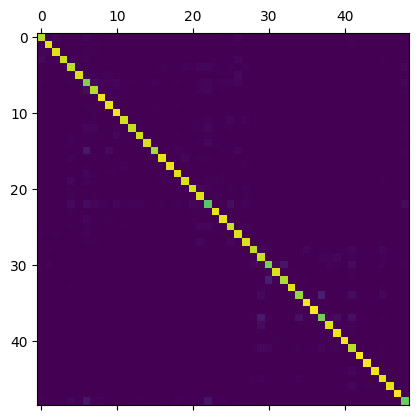

[[1771.   11.   36.    6.    7.    1.   27.   11.    1.    4.    2.    3.    0.    0.    1.    1.    2.    0.    1.    1.    1.   10.    3.    7.    9.    2.   39.    3.    6.    3.    3.    2.    0.    1.    0.    0.    0.    1.    2.    0.    0.    8.    1.    0.    1.    3.    0.    0.    9.]
 [   5. 1914.    7.    2.    2.    0.    4.   13.    2.    1.    1.    0.    1.    0.    0.    0.    0.    0.    4.    0.    0.    0.    0.    0.    2.    4.    1.    2.    2.    1.    5.    2.    1.    2.    0.    1.    0.    2.    3.    1.    1.    9.    0.    0.    0.    2.    1.    0.    2.]
 [  16.   25. 1901.    4.    0.    0.   14.   13.    2.    0.    2.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    2.    0.    0.    0.    4.    2.    0.    5.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    1.    1.    0.    1.    4.    0.    0.    1.]
 [  49.    4.   17. 1833.    0.    0.   20.    0.    6.    4.    5.    0.    0.    0.    2.    0.    0.    0.

In [7]:
matrix = models.confusion_matrix(classifier, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

In [5]:
torch.save(classifier.model.state_dict(), "trained_models/mamba_v3/model.pt2")

# Transformer

In [4]:
from torch import arange
from torch.nn import (Module, Linear, Embedding, TransformerEncoderLayer,
                      TransformerEncoder)
from torch.optim import Adam, AdamW


class T(Module):
    def __init__(self, N, M):
        super(T, self).__init__()
        embed_dim = 128
        vocab_size = 256
        self.token_embedding = Embedding(vocab_size + 1, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=4,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=4)
        self.mlm_head = nn.Linear(embed_dim, vocab_size + 1)
        self.classifier = Linear(embed_dim, M)

    def forward(self, x, mlm=None):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        h = self.transformer_encoder(x)  # [B, L, D]
        if mlm is not None:
            logits = self.mlm_head(h)  # [B, L, vocab_size + 1]
            return logits
        else:
            h = h.mean(dim=1)  # [B, D] - average pooling
            logits = self.classifier(h)  # [B, num_classes]
            return logits


classifier = models.Classifier(
    LENGTH // 4,
    mapping,
    "cuda",
    T,
    format.to_tetramers,
    True
)

print("Pretraining:")
optimizer = AdamW(classifier.get_parameters(), lr=0.001)
pretraining_data = DataLoader(
    models.SyntheticTetramerDataset(PROCESSED_PRETRAINING_DATA, labels=False),
    batch_size=BATCH_SIZE,
    shuffle=True
)
classifier.pretrain(
    pretraining_data,
    optimizer,
    20_000,
    256,
    patience=3,
    mlm_probability=0.05
)
# classifier.model.freeze_base()

print("Fine-tuning:")
model = benchmark(
    classifier,
    "Transformer",
    max_epochs=10,
    loss_fn=nn.CrossEntropyLoss(),
    evaluation_interval=2000,
    learning_rate=0.0001
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

Pretraining:


  3%|▎         | 501/19473 [01:39<1:00:51,  5.20it/s]

Step: 500. Epoch: 1. MLM loss: 5.3901. Patience: 3
Average entropy: 5.3419. Correct predictions: 19043 / 1199798 (1.5872 %).


  5%|▌         | 1001/19473 [03:15<59:20,  5.19it/s] 

Step: 1000. Epoch: 1. MLM loss: 5.3505. Patience: 3
Average entropy: 5.3026. Correct predictions: 21861 / 1200617 (1.8208 %).


  8%|▊         | 1501/19473 [04:51<57:29,  5.21it/s]

Step: 1500. Epoch: 1. MLM loss: 5.3399. Patience: 3
Average entropy: 5.2836. Correct predictions: 22487 / 1201967 (1.8709 %).


 10%|█         | 2001/19473 [06:27<55:36,  5.24it/s]

Step: 2000. Epoch: 1. MLM loss: 5.3304. Patience: 3
Average entropy: 5.2656. Correct predictions: 23245 / 1199574 (1.9378 %).


 13%|█▎        | 2501/19473 [08:03<54:04,  5.23it/s]

Step: 2500. Epoch: 1. MLM loss: 5.3292. Patience: 3
Average entropy: 5.2466. Correct predictions: 23012 / 1198153 (1.9206 %).


 15%|█▌        | 3001/19473 [09:38<52:26,  5.24it/s]

Step: 3000. Epoch: 1. MLM loss: 5.3246. Patience: 3
Average entropy: 5.2293. Correct predictions: 23351 / 1201074 (1.9442 %).


 18%|█▊        | 3501/19473 [11:14<50:51,  5.23it/s]

Step: 3500. Epoch: 1. MLM loss: 5.3236. Patience: 3
Average entropy: 5.2126. Correct predictions: 23440 / 1198886 (1.9551 %).


 21%|██        | 4001/19473 [12:49<49:10,  5.24it/s]

Step: 4000. Epoch: 1. MLM loss: 5.3234. Patience: 3
Average entropy: 5.193. Correct predictions: 23265 / 1199027 (1.9403 %).


 23%|██▎       | 4501/19473 [14:24<47:32,  5.25it/s]

Step: 4500. Epoch: 1. MLM loss: 5.3220. Patience: 3
Average entropy: 5.1718. Correct predictions: 23486 / 1201539 (1.9547 %).


 26%|██▌       | 5001/19473 [16:00<45:56,  5.25it/s]

Step: 5000. Epoch: 1. MLM loss: 5.3226. Patience: 3
Average entropy: 5.1556. Correct predictions: 23301 / 1199560 (1.9425 %).


 28%|██▊       | 5501/19473 [17:35<44:17,  5.26it/s]

Step: 5500. Epoch: 1. MLM loss: 5.3202. Patience: 2
Average entropy: 5.1567. Correct predictions: 23424 / 1197782 (1.9556 %).


 31%|███       | 6001/19473 [19:10<42:53,  5.23it/s]

Step: 6000. Epoch: 1. MLM loss: 5.3199. Patience: 2
Average entropy: 5.1306. Correct predictions: 23653 / 1197740 (1.9748 %).


 33%|███▎      | 6501/19473 [20:46<41:22,  5.23it/s]

Step: 6500. Epoch: 1. MLM loss: 5.3196. Patience: 2
Average entropy: 5.0883. Correct predictions: 23173 / 1199484 (1.9319 %).


 36%|███▌      | 7001/19473 [22:21<39:43,  5.23it/s]

Step: 7000. Epoch: 1. MLM loss: 5.3183. Patience: 2
Average entropy: 5.0799. Correct predictions: 23748 / 1198899 (1.9808 %).


 39%|███▊      | 7501/19473 [23:57<38:15,  5.21it/s]

Step: 7500. Epoch: 1. MLM loss: 5.3186. Patience: 2
Average entropy: 5.0412. Correct predictions: 23215 / 1200595 (1.9336 %).


 41%|████      | 8001/19473 [25:33<36:41,  5.21it/s]

Step: 8000. Epoch: 1. MLM loss: 5.3179. Patience: 1
Average entropy: 5.025. Correct predictions: 23755 / 1200409 (1.9789 %).


 44%|████▎     | 8501/19473 [27:09<35:03,  5.22it/s]

Step: 8500. Epoch: 1. MLM loss: 5.3170. Patience: 1
Average entropy: 5.0311. Correct predictions: 23982 / 1199347 (1.9996 %).


 46%|████▌     | 9001/19473 [28:45<33:19,  5.24it/s]

Step: 9000. Epoch: 1. MLM loss: 5.3152. Patience: 1
Average entropy: 5.0027. Correct predictions: 23926 / 1198835 (1.9958 %).


 49%|████▉     | 9499/19473 [30:20<31:51,  5.22it/s]


Step: 9500. Epoch: 1. MLM loss: 5.3159. Patience: 1
Average entropy: 5.0208. Correct predictions: 24436 / 1201906 (2.0331 %).
Overfitting; stopping early.
Fine-tuning:
Number of parameters: 913_458


  0%|          | 3/9196 [00:24<19:43:54,  7.73s/it]

P: [0.33184, 0.034708]


 11%|█         | 1002/9196 [03:54<11:05:21,  4.87s/it]

P: [0.77585, 0.58068]


 22%|██▏       | 2002/9196 [07:24<9:43:27,  4.87s/it] 

P: [0.79995, 0.63091]


 44%|████▎     | 4002/9196 [14:00<7:01:19,  4.87s/it]

P: [0.81148, 0.67156]


 65%|██████▌   | 6002/9196 [20:37<4:19:59,  4.88s/it]

P: [0.85178, 0.70016]


 87%|████████▋ | 8002/9196 [27:15<1:37:01,  4.88s/it]

P: [0.84238, 0.70859]


100%|██████████| 9196/9196 [30:59<00:00,  4.95it/s]  


1/10 T loss: 3.47714. V loss: 2.84366. F1: [0.84651, 0.71103]. P: [0.84412, 0.71645] Patience: 3


  0%|          | 3/9196 [00:23<18:48:38,  7.37s/it]

P: [0.84302, 0.70841]


 11%|█         | 1002/9196 [03:52<11:06:08,  4.88s/it]

P: [0.85857, 0.7309]


 22%|██▏       | 2002/9196 [07:22<9:45:15,  4.88s/it] 

P: [0.84688, 0.72656]


 44%|████▎     | 4002/9196 [13:59<7:05:50,  4.92s/it] 

P: [0.86536, 0.73518]


 65%|██████▌   | 6002/9196 [20:40<4:23:27,  4.95s/it]

P: [0.86108, 0.73801]


 87%|████████▋ | 8002/9196 [27:20<1:37:50,  4.92s/it]

P: [0.86943, 0.74343]


100%|██████████| 9196/9196 [31:04<00:00,  4.93it/s]  


2/10 T loss: 2.64411. V loss: 2.56356. F1: [0.86215, 0.74755]. P: [0.86454, 0.75337] Patience: 3


  0%|          | 3/9196 [00:23<18:57:09,  7.42s/it]

P: [0.86557, 0.74995]


 11%|█         | 1002/9196 [03:53<11:14:41,  4.94s/it]

P: [0.87025, 0.7522]


 12%|█▏        | 1065/9196 [04:06<31:18,  4.33it/s]   


KeyboardInterrupt: 

# Mamba-Transformer Hybrid

In [ ]:
from torch import arange
from torch.optim import Adam, AdamW
import torch
from torch.nn import Embedding, TransformerEncoderLayer, TransformerEncoder
from mamba_ssm import Mamba
from torch import nn


class MambaBlock(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )

    def forward(self, x):
        # Pre-norm + residual connection
        return x + self.mamba(self.norm(x))


class MambaSequenceClassifier(nn.Module):
    def __init__(
        self,
        N: int,
        num_classes: int,
        n_mamba_layers: int = 4,
        n_transformer_layers: int = 4,
        vocab_size: int = 256,
        d_model: int = 128,
        d_state: int = 16,
        d_conv: int = 4,
        expand: int = 2,
        pooling = "mean",
        dropout: float = 0.1,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, d_model)
        self.mamba_layers = nn.ModuleList([
            MambaBlock(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand)
            for _ in range(n_mamba_layers)
        ])
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model,
            nhead=4,
            dim_feedforward=d_model * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_1 = TransformerEncoder(encoder_layer, num_layers=n_transformer_layers)
        self.position_embedding = Embedding(N, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.classifying_head = nn.Linear(d_model, num_classes)
        self.pooling = pooling
        self.mlm_head = nn.Linear(d_model, vocab_size + 1)

    def forward(self, x: torch.LongTensor, mlm=None) -> torch.Tensor:
        h = self.embedding(x)
        for block in self.mamba_layers:
            h = block(h)   # [B, L, d_model]
        h = self.norm(h)
        batch_size, seq_len, _ = h.size()
        positions = arange(seq_len, device=h.device).unsqueeze(0).expand(batch_size, seq_len)
        h = h + self.position_embedding(positions)  # [B, L, d_model]
        h = self.transformer_1(h)
        if mlm is not None:
            logits = self.mlm_head(h)  # [B, L, vocab_size + 1]
            return logits
        else:
            pooled = h.mean(dim=1)  # [B, d_model]
            pooled = self.dropout(pooled)
            logits = self.classifying_head(pooled)  # [B, num_classes]
            return logits


classifier = models.Classifier(
    LENGTH // 4,
    mapping,
    "cuda",
    MambaSequenceClassifier,
    format.to_tetramers,
    True
)

print("Pretraining:")
optimizer = AdamW(classifier.get_parameters(), lr=0.001)
pretraining_data = DataLoader(
    models.SyntheticTetramerDataset(PROCESSED_PRETRAINING_DATA, labels=False),
    batch_size=BATCH_SIZE,
    shuffle=True
)
classifier.pretrain(
    pretraining_data,
    optimizer,
    20_000,
    256,
    patience=3,
    mlm_probability=0.3
)

print("Fine-tuning:")
model = benchmark(
    classifier,
    "MAMBA",
    max_epochs=10,
    loss_fn=nn.CrossEntropyLoss(),
    evaluation_interval=2000,
    learning_rate=0.0001
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)


# 30 %, 1 mamba, 4 layer transformer, 128 embedding
# Step: 17000. Epoch: 1. MLM loss: 5.1003. Patience: 1
# Average entropy: 5.0083. Correct predictions: 225983 / 7201924 (3.1378 %).
# 1/10 T loss: 2.23986. V loss: 1.75391. F1: [0.92957, 0.82463]. P: [0.94515, 0.83342] Patience: 3
# 2/10 T loss: 1.51715. V loss: 1.43216. F1: [0.93843, 0.85599]. P: [0.93894, 0.85787] Patience: 3
# 3/10 T loss: 1.29859. V loss: 1.37382. F1: [0.94612, 0.86428]. P: [0.94224, 0.86721] Patience: 3

# 30 %, 4 mamba, 4 layer transformer, 128 embedding
# Step: 15000. Epoch: 1. MLM loss: 5.0936. Patience: 1
# Average entropy: 5.042. Correct predictions: 228743 / 7197108 (3.1783 %).
# 1/10 T loss: 2.10920. V loss: 1.64894. F1: [0.93616, 0.83679]. P: [0.93671, 0.83969] Patience: 3
# 2/10 T loss: 1.40372. V loss: 1.29262. F1: [0.94564, 0.86883]. P: [0.93544, 0.8666] Patience: 3
# 3/10 T loss: 1.18623. V loss: 1.16322. F1: [0.95463, 0.88472]. P: [0.95337, 0.8837] Patience: 3

/mnt/d/maitrise/stelaro/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pretraining:


  3%|▎         | 500/19473 [02:46<1:42:58,  3.07it/s]

Step: 500. Epoch: 1. MLM loss: 5.3635. Patience: 3
Average entropy: 5.315. Correct predictions: 121831 / 7199276 (1.6923 %).


  5%|▌         | 1000/19473 [05:30<1:41:07,  3.04it/s]

Step: 1000. Epoch: 1. MLM loss: 5.2760. Patience: 3
Average entropy: 5.2028. Correct predictions: 160857 / 7201461 (2.2337 %).


  8%|▊         | 1500/19473 [08:14<1:37:57,  3.06it/s]

Step: 1500. Epoch: 1. MLM loss: 5.2462. Patience: 3
Average entropy: 5.1724. Correct predictions: 171742 / 7199129 (2.3856 %).


 10%|█         | 2000/19473 [10:57<1:35:34,  3.05it/s]

Step: 2000. Epoch: 1. MLM loss: 5.2263. Patience: 3
Average entropy: 5.1503. Correct predictions: 179562 / 7197665 (2.4947 %).


 13%|█▎        | 2500/19473 [13:41<1:32:35,  3.05it/s]

Step: 2500. Epoch: 1. MLM loss: 5.1971. Patience: 3
Average entropy: 5.1374. Correct predictions: 188240 / 7199173 (2.6147 %).


 15%|█▌        | 3000/19473 [16:25<1:29:59,  3.05it/s]

Step: 3000. Epoch: 1. MLM loss: 5.1775. Patience: 3
Average entropy: 5.1277. Correct predictions: 191270 / 7201211 (2.6561 %).


 18%|█▊        | 3500/19473 [19:08<1:27:11,  3.05it/s]

Step: 3500. Epoch: 1. MLM loss: 5.1666. Patience: 3
Average entropy: 5.1212. Correct predictions: 195376 / 7201845 (2.7129 %).


 21%|██        | 4000/19473 [21:52<1:24:42,  3.04it/s]

Step: 4000. Epoch: 1. MLM loss: 5.1622. Patience: 3
Average entropy: 5.115. Correct predictions: 198943 / 7201293 (2.7626 %).


 23%|██▎       | 4500/19473 [24:36<1:22:01,  3.04it/s]

Step: 4500. Epoch: 1. MLM loss: 5.1564. Patience: 3
Average entropy: 5.1126. Correct predictions: 201937 / 7199942 (2.8047 %).


 26%|██▌       | 5000/19473 [27:21<1:19:11,  3.05it/s]

Step: 5000. Epoch: 1. MLM loss: 5.1496. Patience: 3
Average entropy: 5.1105. Correct predictions: 204343 / 7199795 (2.8382 %).


 28%|██▊       | 5500/19473 [30:05<1:16:38,  3.04it/s]

Step: 5500. Epoch: 1. MLM loss: 5.1456. Patience: 3
Average entropy: 5.1056. Correct predictions: 205728 / 7201354 (2.8568 %).


 31%|███       | 6000/19473 [32:49<1:13:31,  3.05it/s]

Step: 6000. Epoch: 1. MLM loss: 5.1420. Patience: 3
Average entropy: 5.103. Correct predictions: 208736 / 7198751 (2.8996 %).


 33%|███▎      | 6500/19473 [35:32<1:10:45,  3.06it/s]

Step: 6500. Epoch: 1. MLM loss: 5.1394. Patience: 3
Average entropy: 5.0997. Correct predictions: 208250 / 7198792 (2.8928 %).


 36%|███▌      | 7000/19473 [38:16<1:08:01,  3.06it/s]

Step: 7000. Epoch: 1. MLM loss: 5.1366. Patience: 3
Average entropy: 5.0989. Correct predictions: 210919 / 7201998 (2.9286 %).


 39%|███▊      | 7500/19473 [40:59<1:05:20,  3.05it/s]

Step: 7500. Epoch: 1. MLM loss: 5.1297. Patience: 3
Average entropy: 5.0893. Correct predictions: 214843 / 7201996 (2.9831 %).


 41%|████      | 8000/19473 [43:43<1:02:46,  3.05it/s]

Step: 8000. Epoch: 1. MLM loss: 5.1252. Patience: 3
Average entropy: 5.084. Correct predictions: 216442 / 7200073 (3.0061 %).


 44%|████▎     | 8500/19473 [46:27<1:00:03,  3.04it/s]

Step: 8500. Epoch: 1. MLM loss: 5.1218. Patience: 3
Average entropy: 5.0793. Correct predictions: 217043 / 7199758 (3.0146 %).


 46%|████▌     | 9000/19473 [49:11<57:06,  3.06it/s]  

Step: 9000. Epoch: 1. MLM loss: 5.1151. Patience: 3
Average entropy: 5.0726. Correct predictions: 220392 / 7200516 (3.0608 %).


 49%|████▉     | 9500/19473 [51:56<56:40,  2.93it/s]

Step: 9500. Epoch: 1. MLM loss: 5.1126. Patience: 3
Average entropy: 5.069. Correct predictions: 219227 / 7200343 (3.0447 %).


 51%|█████▏    | 10000/19473 [54:40<51:51,  3.04it/s]

Step: 10000. Epoch: 1. MLM loss: 5.1119. Patience: 3
Average entropy: 5.0673. Correct predictions: 218593 / 7200251 (3.0359 %).


 54%|█████▍    | 10500/19473 [57:24<49:02,  3.05it/s]

Step: 10500. Epoch: 1. MLM loss: 5.1072. Patience: 3
Average entropy: 5.06. Correct predictions: 221005 / 7199859 (3.0696 %).


 56%|█████▋    | 11000/19473 [1:00:08<46:22,  3.05it/s]

Step: 11000. Epoch: 1. MLM loss: 5.1051. Patience: 3
Average entropy: 5.0583. Correct predictions: 224202 / 7196697 (3.1153 %).


 59%|█████▉    | 11500/19473 [1:02:52<43:28,  3.06it/s]

Step: 11500. Epoch: 1. MLM loss: 5.1018. Patience: 3
Average entropy: 5.0532. Correct predictions: 225805 / 7200530 (3.1359 %).


 62%|██████▏   | 12000/19473 [1:05:35<40:37,  3.07it/s]

Step: 12000. Epoch: 1. MLM loss: 5.0990. Patience: 3
Average entropy: 5.0498. Correct predictions: 227338 / 7202099 (3.1566 %).


 64%|██████▍   | 12500/19473 [1:08:19<37:57,  3.06it/s]

Step: 12500. Epoch: 1. MLM loss: 5.0992. Patience: 3
Average entropy: 5.0473. Correct predictions: 226709 / 7201498 (3.1481 %).


 67%|██████▋   | 13000/19473 [1:11:02<35:14,  3.06it/s]

Step: 13000. Epoch: 1. MLM loss: 5.0981. Patience: 2
Average entropy: 5.0473. Correct predictions: 226796 / 7204596 (3.1479 %).


 69%|██████▉   | 13500/19473 [1:13:45<32:27,  3.07it/s]

Step: 13500. Epoch: 1. MLM loss: 5.0944. Patience: 2
Average entropy: 5.0437. Correct predictions: 227208 / 7199732 (3.1558 %).


 72%|███████▏  | 14000/19473 [1:16:28<29:41,  3.07it/s]

Step: 14000. Epoch: 1. MLM loss: 5.0957. Patience: 2
Average entropy: 5.0452. Correct predictions: 228300 / 7195505 (3.1728 %).


 74%|███████▍  | 14500/19473 [1:19:11<27:04,  3.06it/s]

Step: 14500. Epoch: 1. MLM loss: 5.0926. Patience: 1
Average entropy: 5.0449. Correct predictions: 229420 / 7195075 (3.1886 %).


 77%|███████▋  | 14999/19473 [1:21:54<24:24,  3.05it/s]

Step: 15000. Epoch: 1. MLM loss: 5.0936. Patience: 1
Average entropy: 5.042. Correct predictions: 228743 / 7197108 (3.1783 %).
Overfitting; stopping early.


 77%|███████▋  | 14999/19473 [1:21:54<24:26,  3.05it/s]


Fine-tuning:
Number of parameters: 1_380_658


  0%|          | 1/9196 [00:01<3:11:41,  1.25s/it]

Halting evaluation after 45056 data points.


  0%|          | 2/9196 [00:32<47:43:04, 18.68s/it]

P: [0.42241, 0.049277]


 11%|█         | 1000/9196 [05:58<44:25,  3.07it/s]

Halting evaluation after 44416 data points.


 11%|█         | 1001/9196 [06:29<21:30:43,  9.45s/it]

P: [0.88077, 0.73259]


 22%|██▏       | 2000/9196 [11:57<38:47,  3.09it/s]   

Halting evaluation after 45184 data points.


 22%|██▏       | 2001/9196 [12:28<18:51:49,  9.44s/it]

P: [0.92094, 0.7857]


 43%|████▎     | 4000/9196 [23:13<27:59,  3.09it/s]   

Halting evaluation after 45056 data points.


 44%|████▎     | 4001/9196 [23:44<13:37:41,  9.44s/it]

P: [0.90554, 0.79134]


 65%|██████▌   | 6000/9196 [34:29<17:11,  3.10it/s]   

Halting evaluation after 45312 data points.


 65%|██████▌   | 6001/9196 [35:00<8:23:17,  9.45s/it]

P: [0.91446, 0.82309]


 87%|████████▋ | 8000/9196 [45:46<06:26,  3.09it/s]  

Halting evaluation after 45184 data points.


 87%|████████▋ | 8001/9196 [46:17<3:08:16,  9.45s/it]

P: [0.93206, 0.83903]


100%|██████████| 9196/9196 [52:43<00:00,  2.91it/s]  


Halting evaluation after 10752 data points.
1/10 T loss: 2.10920. V loss: 1.64894. F1: [0.93616, 0.83679]. P: [0.93671, 0.83969] Patience: 3


  0%|          | 1/9196 [00:01<4:58:45,  1.95s/it]

Halting evaluation after 45312 data points.


  0%|          | 2/9196 [00:32<48:22:38, 18.94s/it]

P: [0.9389, 0.84388]


 11%|█         | 1000/9196 [08:09<1:02:12,  2.20it/s]

Halting evaluation after 45312 data points.


 11%|█         | 1001/9196 [08:40<22:00:32,  9.67s/it]

P: [0.92117, 0.83738]


 22%|██▏       | 2000/9196 [16:17<54:50,  2.19it/s]   

Halting evaluation after 45184 data points.


 22%|██▏       | 2001/9196 [16:48<19:10:30,  9.59s/it]

P: [0.94153, 0.85287]


 43%|████▎     | 4000/9196 [32:00<39:21,  2.20it/s]   

Halting evaluation after 45440 data points.


 44%|████▎     | 4001/9196 [32:31<13:49:39,  9.58s/it]

P: [0.94455, 0.86431]


 65%|██████▌   | 6000/9196 [47:44<24:19,  2.19it/s]   

Halting evaluation after 45184 data points.


 65%|██████▌   | 6001/9196 [48:15<8:30:18,  9.58s/it]

P: [0.94252, 0.86594]


 87%|████████▋ | 8000/9196 [1:03:28<09:03,  2.20it/s]

Halting evaluation after 45312 data points.


 87%|████████▋ | 8001/9196 [1:03:59<3:10:31,  9.57s/it]

P: [0.94374, 0.87343]


100%|██████████| 9196/9196 [1:13:04<00:00,  2.10it/s]  


Halting evaluation after 4608 data points.
2/10 T loss: 1.40372. V loss: 1.29262. F1: [0.94564, 0.86883]. P: [0.93544, 0.8666] Patience: 3


  0%|          | 1/9196 [00:01<3:42:40,  1.45s/it]

Halting evaluation after 45312 data points.


  0%|          | 2/9196 [00:32<47:50:16, 18.73s/it]

P: [0.93347, 0.86915]


 11%|█         | 1000/9196 [08:07<1:02:11,  2.20it/s]

Halting evaluation after 45056 data points.


 11%|█         | 1001/9196 [08:38<21:46:39,  9.57s/it]

P: [0.94521, 0.87296]


 22%|██▏       | 2000/9196 [16:13<54:24,  2.20it/s]   

Halting evaluation after 45568 data points.


 22%|██▏       | 2001/9196 [16:44<19:07:55,  9.57s/it]

P: [0.94917, 0.87066]


 43%|████▎     | 4000/9196 [31:54<39:34,  2.19it/s]   

Halting evaluation after 45184 data points.


 44%|████▎     | 4001/9196 [32:25<13:49:47,  9.58s/it]

P: [0.95564, 0.88122]


 65%|██████▌   | 6000/9196 [47:36<24:23,  2.18it/s]   

Halting evaluation after 45184 data points.


 65%|██████▌   | 6001/9196 [48:07<8:30:12,  9.58s/it]

P: [0.95554, 0.87495]


 87%|████████▋ | 8000/9196 [1:03:21<09:10,  2.17it/s]

Halting evaluation after 45056 data points.


 87%|████████▋ | 8001/9196 [1:03:52<3:10:34,  9.57s/it]

P: [0.94866, 0.8824]


100%|██████████| 9196/9196 [1:12:59<00:00,  2.10it/s]  


Halting evaluation after 4608 data points.
3/10 T loss: 1.18623. V loss: 1.16322. F1: [0.95463, 0.88472]. P: [0.95337, 0.8837] Patience: 3


  0%|          | 1/9196 [00:01<3:40:22,  1.44s/it]

Halting evaluation after 45184 data points.


  0%|          | 2/9196 [00:32<47:54:38, 18.76s/it]

P: [0.95628, 0.88725]


  5%|▍         | 426/9196 [03:47<1:17:55,  1.88it/s]


KeyboardInterrupt: 

In [ ]:
result = models.evaluate(classifier, test_data, "cuda", mapping)
rounded_result = [float(f"{r:.5}") for r in result]
print(f"F1: {rounded_result}")
result = models.evaluate_precision(classifier, test_data, "cuda", mapping)
rounded_result = [float(f"{r:.5}") for r in result]
print(f"Precision: {rounded_result}")

F1: [0.95535, 0.88538]
Precision: [0.95351, 0.88893]


: 

# Hierarchical

In [ ]:
BERTAX_TRAIN = BERTAX_DIRECTORY + "train/"
BERTAX_VALIDATION = BERTAX_DIRECTORY + "validation/"
BERTAX_TEST = BERTAX_DIRECTORY + "test/"

from time import time
import json
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn

from stelaro import models
from stelaro.models import autoencoder, feedforward, transformer

LENGTH = 1500
BATCH_SIZE = 64

with open(BERTAX_DIRECTORY + "statistics/map.json", "r") as f:
    mapping = json.load(f)


train_data = DataLoader(
    models.SyntheticMultiLevelTetramerDataset(
        BERTAX_TRAIN,
        mapping,
        (),
        1,
        balance = True,
        other_factor = 0
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)
validation_data = DataLoader(
    models.SyntheticMultiLevelTetramerDataset(
        BERTAX_VALIDATION,
        mapping,
        (),
        1,
        balance = False,
        other_factor = 0
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_data = DataLoader(
    models.SyntheticMultiLevelTetramerDataset(
        BERTAX_TEST,
        mapping,
        (),
        1,
        balance = False,
        other_factor = 0
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)
mapping = train_data.dataset.mapping


def benchmark(
        classifier: models.Classifier,
        name: str,
        max_epochs: int = 20,
        learning_rate: float = 0.001
    ):
    parameters = classifier.get_parameters()
    if parameters:
        optimizer = Adam(classifier.get_parameters(), lr=learning_rate)
        total_params = sum(param.numel() for param in parameters)
        print(f"Number of parameters: {total_params:_}")
    else:
        optimizer = None
    a = time()
    losses, f1, validation_losses = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=max_epochs,
        patience=3,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=5000,
    )
    b = time()
    print(f"Training took {(b - a):.3f} s.")
    if losses:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        x = list(range(len(losses)))
        ax[0].plot(x, losses, label="Training")
        ax[0].plot(x, validation_losses, label="Validation")
        ax[0].set(xlabel='Epochs', ylabel='Loss')
        ax[0].set_title("Normalized Loss Against Epochs")
        ax[0].legend()
        ax[1].set(xlabel='Epochs', ylabel="f1")
        ax[1].set_title("F1 Score")
        r = 0
        for f in f1:
            ax[1].plot(x, f, label=f'Rank {r}')
            r += 1
        ax[1].legend()
        fig.suptitle(f"Classification Training for {name}")
        plt.show()
    result = models.evaluate(classifier, test_data, "cuda", mapping)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"Test F1 score: {rounded_result}")

    result = models.evaluate_precision(classifier, test_data, "cuda", mapping)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"Test precision score: {rounded_result}")

    return classifier